In [1]:
import pandas as pd 
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

import subprocess
import re

from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from matplotlib.colors import LinearSegmentedColormap

from sklearn.feature_selection import RFE
import optuna
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import GradientBoostingRegressor as GBR
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df=pd.read_csv("./c2db_HSE.csv")
df

Formula Bandgap(pbe) Bandgap(HSE06) cbm(pbe) cbm(HSE06) vbm(pbe)  \
0          Be4            0              -        -          -        -   
1        As4O8        3.232              -   -3.938          -    -7.17   
2       Ca4As4        0.998          1.583   -1.024     -0.715   -2.022   
3        Fe4S8            0              -        -          -        -   
4       In2Se2         1.63          2.254   -2.271     -2.039   -3.901   
...        ...          ...            ...      ...        ...      ...   
4029   Rh2P2S6            0              0        -          -        -   
4030  Ta2P2Se6        0.294          0.813   -0.799     -0.502   -1.093   
4031  Zr2P2Se6        0.394          1.074   -1.142     -0.712   -1.536   
4032  Mo2W2Se8         1.27          1.749    0.853      1.226   -0.417   
4033    FeZrI6        0.661          2.598   -0.849     -0.201    -1.51   

     vbm(HSE06)  Energy_above_hull  Space group number Space group Fermi level  
0             -              0.425                  67        Cmme      -3.609  
1             -              0.058                  31      Pmn2_1      -5.554  
2        -2.298              0.350                  14      P2_1/c      -1.523  
3             -              0.363                   7          Pc      -2.792  
4        -4.293              0.038                  12        C2/m      -3.086  
...         ...                ...                 ...         ...         ...  
4029          -              0.068                 162       P-31m      -0.878  
4030     -1.315              0.227                   2         P-1      -0.946  
4031     -1.786              0.191                   2         P-1      -1.339  
4032     -0.523              0.000                  25        Pmm2       0.218  
4033     -2.799              0.088                 149        P312      -1.179  

[4034 rows x 11 columns]

In [3]:
columns_to_convert = ['Bandgap(pbe)','Bandgap(HSE06)','cbm(pbe)','cbm(HSE06)','vbm(pbe)','vbm(HSE06)','Energy_above_hull','Space group number']

# Converts "-" to NaN and the column to numeric type
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Output the processed DataFrame
df

Formula  Bandgap(pbe)  Bandgap(HSE06)  cbm(pbe)  cbm(HSE06)  vbm(pbe)  \
0          Be4         0.000             NaN       NaN         NaN       NaN   
1        As4O8         3.232             NaN    -3.938         NaN    -7.170   
2       Ca4As4         0.998           1.583    -1.024      -0.715    -2.022   
3        Fe4S8         0.000             NaN       NaN         NaN       NaN   
4       In2Se2         1.630           2.254    -2.271      -2.039    -3.901   
...        ...           ...             ...       ...         ...       ...   
4029   Rh2P2S6         0.000           0.000       NaN         NaN       NaN   
4030  Ta2P2Se6         0.294           0.813    -0.799      -0.502    -1.093   
4031  Zr2P2Se6         0.394           1.074    -1.142      -0.712    -1.536   
4032  Mo2W2Se8         1.270           1.749     0.853       1.226    -0.417   
4033    FeZrI6         0.661           2.598    -0.849      -0.201    -1.510   

      vbm(HSE06)  Energy_above_hull  Space group number Space group  \
0            NaN              0.425                  67        Cmme   
1            NaN              0.058                  31      Pmn2_1   
2         -2.298              0.350                  14      P2_1/c   
3            NaN              0.363                   7          Pc   
4         -4.293              0.038                  12        C2/m   
...          ...                ...                 ...         ...   
4029         NaN              0.068                 162       P-31m   
4030      -1.315              0.227                   2         P-1   
4031      -1.786              0.191                   2         P-1   
4032      -0.523              0.000                  25        Pmm2   
4033      -2.799              0.088                 149        P312   

     Fermi level  
0         -3.609  
1         -5.554  
2         -1.523  
3         -2.792  
4         -3.086  
...          ...  
4029      -0.878  
4030      -0.946  
4031      -1.339  
4032       0.218  
4033      -1.179  

[4034 rows x 11 columns]

In [4]:
# Establish pbe bandgap regression model

In [5]:
watncols=['Formula','Bandgap(pbe)','Space group number','cbm(pbe)','vbm(pbe)']
dfpbe=df[watncols]
dfpbe

Formula  Bandgap(pbe)  Space group number  cbm(pbe)  vbm(pbe)
0          Be4         0.000                  67       NaN       NaN
1        As4O8         3.232                  31    -3.938    -7.170
2       Ca4As4         0.998                  14    -1.024    -2.022
3        Fe4S8         0.000                   7       NaN       NaN
4       In2Se2         1.630                  12    -2.271    -3.901
...        ...           ...                 ...       ...       ...
4029   Rh2P2S6         0.000                 162       NaN       NaN
4030  Ta2P2Se6         0.294                   2    -0.799    -1.093
4031  Zr2P2Se6         0.394                   2    -1.142    -1.536
4032  Mo2W2Se8         1.270                  25     0.853    -0.417
4033    FeZrI6         0.661                 149    -0.849    -1.510

[4034 rows x 5 columns]

In [6]:
# Delete NaN values
dfpbe=dfpbe.dropna(subset=['Formula','Bandgap(pbe)','Space group number'])
dfpbe

Formula  Bandgap(pbe)  Space group number  cbm(pbe)  vbm(pbe)
0          Be4         0.000                  67       NaN       NaN
1        As4O8         3.232                  31    -3.938    -7.170
2       Ca4As4         0.998                  14    -1.024    -2.022
3        Fe4S8         0.000                   7       NaN       NaN
4       In2Se2         1.630                  12    -2.271    -3.901
...        ...           ...                 ...       ...       ...
4029   Rh2P2S6         0.000                 162       NaN       NaN
4030  Ta2P2Se6         0.294                   2    -0.799    -1.093
4031  Zr2P2Se6         0.394                   2    -1.142    -1.536
4032  Mo2W2Se8         1.270                  25     0.853    -0.417
4033    FeZrI6         0.661                 149    -0.849    -1.510

[4032 rows x 5 columns]

In [7]:
def get_magpie_plus_features(formulas: pd.Series):
    """
    This function generates Magpie+ features for a given series of chemical formulas.
    
    Parameters:
    formulas (pd.Series): A pandas Series containing chemical formulas.
    
    Returns:
    pd.DataFrame: A DataFrame containing the generated Magpie+ features.
    """
    input_file = "inputFile"
    output_file = "C2DB_predicted_pbe_band_gap_magpie.csv"
    with open('inputFile', 'w') as f:
        formulas.to_csv(f, index=False, header=False, sep='\n')
    
    def run_java_program():
        """
        Runs the Java program to generate Magpie+ features.
        """
        command = ['java', '-jar', 'MaterialDescriptors.jar', input_file, '0', output_file]
        output = subprocess.check_output(command, stderr=subprocess.STDOUT)
        output_str = output.decode()
        comp_number = re.findall(r'\d+', output_str)[0]
        print(f'Successfully generated features for {comp_number} compounds!')
    
    run_java_program()

    return pd.read_csv(output_file)

In [8]:
formulas=dfpbe['Formula']
features=get_magpie_plus_features(formulas)
features

成功生成了4032个化学式的特征！


mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  \
Be4             37.74               0.000                 0.000   
As4O8            5.30              58.183                 0.251   
Ca4As4          30.00              50.000                 0.467   
Fe4S8           19.40              52.685                 0.267   
In2Se2          28.90              50.000                 0.220   
...               ...                 ...                   ...   
Rh2P2S6         19.40              56.535                 0.266   
Ta2P2Se6        28.90              54.882                 0.281   
Zr2P2Se6        28.90              55.976                 0.287   
Mo2W2Se8        28.90              54.594                 0.371   
FeZrI6          32.90              46.505                 0.199   

          meandiff_workfn  min_enthalpyAtomization  fwtmeandev_dipole  \
Be4                   NaN                    324.0              0.000   
As4O8               0.770                    249.0             10.972   
Ca4As4              2.250                    178.0             65.400   
Fe4S8               0.900                    279.0             18.924   
In2Se2              0.130                    227.0             18.050   
...                   ...                      ...                ...   
Rh2P2S6             1.186                    279.0             14.464   
Ta2P2Se6            0.916                    227.0             14.744   
Zr2P2Se6            1.260                    227.0             26.904   
Mo2W2Se8            0.934                    227.0             21.647   
FeZrI6              0.832                    107.0             20.288   

          mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
Be4                0.440                   0.0        1.000           5.050   
As4O8              0.180                   4.0        0.746           4.286   
Ca4As4             0.745                  88.0        0.707           3.675   
Fe4S8              0.560                  41.0        0.746           4.330   
In2Se2             0.670                  17.0        0.707           3.965   
...                  ...                   ...          ...             ...   
Rh2P2S6            0.560                  36.0        0.663           4.608   
Ta2P2Se6           0.670                  52.0        0.663           4.338   
Zr2P2Se6           0.670                  57.0        0.663           4.218   
Mo2W2Se8           0.670                  49.0        0.708           4.375   
FeZrI6             0.830                  65.0        0.771           4.070   

          maxdiff_atmnum  maxdiff_eneg_rahm  fwtmean_eneg_rahm  \
Be4                  0.0               0.00             -9.320   
As4O8               25.0               6.06            -16.552   
Ca4As4              13.0               6.40             -9.310   
Fe4S8               10.0               3.57            -12.451   
In2Se2              15.0               3.94            -11.250   
...                  ...                ...                ...   
Rh2P2S6             30.0               4.32            -12.598   
Ta2P2Se6            58.0               5.43            -12.040   
Zr2P2Se6            25.0               5.70            -11.986   
Mo2W2Se8            40.0               4.91            -11.638   
FeZrI6              27.0               5.83            -12.211   

          fwtmeandev_NpValence  fwtmeandev_spheat  maxdiff_NdUnfValence  \
Be4                      0.000              0.000                   0.0   
As4O8                    0.444            262.535                   0.0   
Ca4As4                   1.500            151.500                   0.0   
Fe4S8                    1.777            113.721                   4.0   
In2Se2                   1.500             44.100                   0.0   
...                        ...                ...                   ...   
Rh2P2S6                  1.200            153.976            

In [9]:
# Merge dfpbe with features based on the 'Formula' column in dfpbe and the index of features
newdfpbe=pd.merge(dfpbe,features,left_on='Formula',right_index=True,how='left')
# Remove duplicate rows based on the combination of 'Formula', 'Bandgap(pbe)', and 'Space group number'
newdfpbe.drop_duplicates(subset=['Formula','Bandgap(pbe)','Space group number'],inplace=True)

newdfpbe.dropna(axis=1,inplace=True)
newdfpbe

Formula  Bandgap(pbe)  Space group number  mode_dipole  \
0          Be4         0.000                  67        37.74   
1        As4O8         3.232                  31         5.30   
2       Ca4As4         0.998                  14        30.00   
3        Fe4S8         0.000                   7        19.40   
4       In2Se2         1.630                  12        28.90   
...        ...           ...                 ...          ...   
4029   Rh2P2S6         0.000                 162        19.40   
4030  Ta2P2Se6         0.294                   2        28.90   
4031  Zr2P2Se6         0.394                   2        28.90   
4032  Mo2W2Se8         1.270                  25        28.90   
4033    FeZrI6         0.661                 149        32.90   

      varianceAtomRadius  fwtmeandev_rad_p_orb  min_enthalpyAtomization  \
0                  0.000                 0.000                    324.0   
1                 58.183                 0.251                    249.0   
2                 50.000                 0.467                    178.0   
3                 52.685                 0.267                    279.0   
4                 50.000                 0.220                    227.0   
...                  ...                   ...                      ...   
4029              56.535                 0.266                    279.0   
4030              54.882                 0.281                    227.0   
4031              55.976                 0.287                    227.0   
4032              54.594                 0.371                    227.0   
4033              46.505                 0.199                    107.0   

      fwtmeandev_dipole  mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  \
0                 0.000           0.440                   0.0        1.000   
1                10.972           0.180                   4.0        0.746   
2                65.400           0.745                  88.0        0.707   
3                18.924           0.560                  41.0        0.746   
4                18.050           0.670                  17.0        0.707   
...                 ...             ...                   ...          ...   
4029             14.464           0.560                  36.0        0.663   
4030             14.744           0.670                  52.0        0.663   
4031             26.904           0.670                  57.0        0.663   
4032             21.647           0.670                  49.0        0.708   
4033             20.288           0.830                  65.0        0.771   

      fwtmean_workfn  maxdiff_atmnum  maxdiff_eneg_rahm  fwtmean_eneg_rahm  \
0              5.050             0.0               0.00             -9.320   
1              4.286            25.0               6.06            -16.552   
2              3.675            13.0               6.40             -9.310   
3              4.330            10.0               3.57            -12.451   
4              3.965            15.0               3.94            -11.250   
...              ...             ...                ...                ...   
4029           4.608            30.0               4.32            -12.598   
4030           4.338            58.0               5.43            -12.040   
4031           4.218            25.0               5.70            -11.986   
4032           4.375            40.0               4.91            -11.638   
4033           4.070            27.0               5.83            -12.211   

      fwtmeandev_NpValence  fwtmeandev_spheat  maxdiff_NdUnfValence  \
0                    0.000              0.000                   0.0   
1                    0.444            262.535                   0.0   
2                    1.500            151.500                   0.0   
3                    1.777            113.721                   4.0   
4                    1.500             44.100                   0.0   
...                    ..

In [10]:
X=newdfpbe.drop(['Formula','Bandgap(pbe)'],axis=1)
X

Space group number  mode_dipole  varianceAtomRadius  \
0                     67        37.74               0.000   
1                     31         5.30              58.183   
2                     14        30.00              50.000   
3                      7        19.40              52.685   
4                     12        28.90              50.000   
...                  ...          ...                 ...   
4029                 162        19.40              56.535   
4030                   2        28.90              54.882   
4031                   2        28.90              55.976   
4032                  25        28.90              54.594   
4033                 149        32.90              46.505   

      fwtmeandev_rad_p_orb  min_enthalpyAtomization  fwtmeandev_dipole  \
0                    0.000                    324.0              0.000   
1                    0.251                    249.0             10.972   
2                    0.467                    178.0             65.400   
3                    0.267                    279.0             18.924   
4                    0.220                    227.0             18.050   
...                    ...                      ...                ...   
4029                 0.266                    279.0             14.464   
4030                 0.281                    227.0             14.744   
4031                 0.287                    227.0             26.904   
4032                 0.371                    227.0             21.647   
4033                 0.199                    107.0             20.288   

      mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
0              0.440                   0.0        1.000           5.050   
1              0.180                   4.0        0.746           4.286   
2              0.745                  88.0        0.707           3.675   
3              0.560                  41.0        0.746           4.330   
4              0.670                  17.0        0.707           3.965   
...              ...                   ...          ...             ...   
4029           0.560                  36.0        0.663           4.608   
4030           0.670                  52.0        0.663           4.338   
4031           0.670                  57.0        0.663           4.218   
4032           0.670                  49.0        0.708           4.375   
4033           0.830                  65.0        0.771           4.070   

      maxdiff_atmnum  maxdiff_eneg_rahm  fwtmean_eneg_rahm  \
0                0.0               0.00             -9.320   
1               25.0               6.06            -16.552   
2               13.0               6.40             -9.310   
3               10.0               3.57            -12.451   
4               15.0               3.94            -11.250   
...              ...                ...                ...   
4029            30.0               4.32            -12.598   
4030            58.0               5.43            -12.040   
4031            25.0               5.70            -11.986   
4032            40.0               4.91            -11.638   
4033            27.0               5.83            -12.211   

      fwtmeandev_NpValence  fwtmeandev_spheat  maxdiff_NdUnfValence  \
0                    0.000              0.000                   0.0   
1                    0.444            262.535                   0.0   
2                    1.500            151.500                   0.0   
3                    1.777            113.721                   4.0   
4                    1.500             44.100                   0.0   
...                    ...                ...                   ...   
4029                 1.200            153.976                   2.0   
4030                 1.200            158.016                   7.0   
4031                 1.200            146.976                   8.0   
4032                 1.780  

In [11]:
# Remove collinear features
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [12]:
newXpbe= remove_collinear_features(X, 0.8);
newXpbe

Space group number  mode_dipole  varianceAtomRadius  \
0                     67        37.74               0.000   
1                     31         5.30              58.183   
2                     14        30.00              50.000   
3                      7        19.40              52.685   
4                     12        28.90              50.000   
...                  ...          ...                 ...   
4029                 162        19.40              56.535   
4030                   2        28.90              54.882   
4031                   2        28.90              55.976   
4032                  25        28.90              54.594   
4033                 149        32.90              46.505   

      fwtmeandev_rad_p_orb  min_enthalpyAtomization  fwtmeandev_dipole  \
0                    0.000                    324.0              0.000   
1                    0.251                    249.0             10.972   
2                    0.467                    178.0             65.400   
3                    0.267                    279.0             18.924   
4                    0.220                    227.0             18.050   
...                    ...                      ...                ...   
4029                 0.266                    279.0             14.464   
4030                 0.281                    227.0             14.744   
4031                 0.287                    227.0             26.904   
4032                 0.371                    227.0             21.647   
4033                 0.199                    107.0             20.288   

      mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
0              0.440                   0.0        1.000           5.050   
1              0.180                   4.0        0.746           4.286   
2              0.745                  88.0        0.707           3.675   
3              0.560                  41.0        0.746           4.330   
4              0.670                  17.0        0.707           3.965   
...              ...                   ...          ...             ...   
4029           0.560                  36.0        0.663           4.608   
4030           0.670                  52.0        0.663           4.338   
4031           0.670                  57.0        0.663           4.218   
4032           0.670                  49.0        0.708           4.375   
4033           0.830                  65.0        0.771           4.070   

      maxdiff_atmnum  maxdiff_eneg_rahm  fwtmean_eneg_rahm  \
0                0.0               0.00             -9.320   
1               25.0               6.06            -16.552   
2               13.0               6.40             -9.310   
3               10.0               3.57            -12.451   
4               15.0               3.94            -11.250   
...              ...                ...                ...   
4029            30.0               4.32            -12.598   
4030            58.0               5.43            -12.040   
4031            25.0               5.70            -11.986   
4032            40.0               4.91            -11.638   
4033            27.0               5.83            -12.211   

      fwtmeandev_NpValence  fwtmeandev_spheat  maxdiff_NdUnfValence  \
0                    0.000              0.000                   0.0   
1                    0.444            262.535                   0.0   
2                    1.500            151.500                   0.0   
3                    1.777            113.721                   4.0   
4                    1.500             44.100                   0.0   
...                    ...                ...                   ...   
4029                 1.200            153.976                   2.0   
4030                 1.200            158.016                   7.0   
4031                 1.200            146.976                   8.0   
4032                 1.780  

In [13]:
y = newdfpbe['Bandgap(pbe)']
X_train, X_test, y_train, y_test = train_test_split(newXpbe, y, test_size=0.1, random_state=42)
'''
Create a RandomForestRegressor model with specified hyperparameters
         n_jobs=-1: Use all available CPU cores for parallel processing
         n_estimators=500: Number of trees in the forest
         min_samples_leaf=1: Minimum number of samples required to be at a leaf node
         min_samples_split=2: Minimum number of samples required to split an internal node
'''
rf_pbe = RandomForestRegressor(n_jobs=-1, n_estimators=500, min_samples_leaf=1, min_samples_split=2)

rf_pbe.fit(X_train, y_train)
y_pred = rf_pbe.predict(X_test)

# Calculate evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)
print("MAE:", mae)

RMSE: 0.47604390279304265
R2 Score: 0.7976417306102591
MAE: 0.2753027816335143


In [15]:
# Remove no metal (guide band valence band is empty)
df=df.dropna(subset=['cbm(HSE06)','vbm(HSE06)'])
df

Formula  Bandgap(pbe)  Bandgap(HSE06)  cbm(pbe)  cbm(HSE06)  vbm(pbe)  \
2       Ca4As4         0.998           1.583    -1.024      -0.715    -2.022   
4       In2Se2         1.630           2.254    -2.271      -2.039    -3.901   
5        Sc4S6         1.515           2.939    -2.166      -1.320    -3.681   
8      Zr2Te10         0.191           0.142    -2.292      -2.128    -2.483   
9     Al2MgSe4         1.064           1.984    -0.789      -0.456    -1.853   
...        ...           ...             ...       ...         ...       ...   
4027   Hg2P2S6         1.020           1.894    -1.412      -1.178    -2.432   
4030  Ta2P2Se6         0.294           0.813    -0.799      -0.502    -1.093   
4031  Zr2P2Se6         0.394           1.074    -1.142      -0.712    -1.536   
4032  Mo2W2Se8         1.270           1.749     0.853       1.226    -0.417   
4033    FeZrI6         0.661           2.598    -0.849      -0.201    -1.510   

      vbm(HSE06)  Energy_above_hull  Space group number Space group  \
2         -2.298              0.350                  14      P2_1/c   
4         -4.293              0.038                  12        C2/m   
5         -4.259              0.263                  65        Cmmm   
8         -2.270              0.000                  59        Pmmn   
9         -2.440              0.000                 164       P-3m1   
...          ...                ...                 ...         ...   
4027      -3.072              0.020                 162       P-31m   
4030      -1.315              0.227                   2         P-1   
4031      -1.786              0.191                   2         P-1   
4032      -0.523              0.000                  25        Pmm2   
4033      -2.799              0.088                 149        P312   

     Fermi level  
2         -1.523  
4         -3.086  
5         -2.924  
8         -2.387  
9         -1.321  
...          ...  
4027      -1.922  
4030      -0.946  
4031      -1.339  
4032       0.218  
4033      -1.179  

[1294 rows x 11 columns]

In [16]:
# # Bandgap and stability do classification, homemade labels
# df['BandgapLable']=df['Bandgap(HSE06)'].apply(lambda x:1 if x>1.5 and x<3.7 else 0)
# df['hullLable']=df['Energy_above_hull'].apply(lambda x:1 if x<=0.2 else 0)
# df

In [17]:
# df['BandgapLable'].value_counts()

In [18]:
# df['hullLable'].value_counts()

In [19]:
def get_magpie_plus_features(formulas: pd.Series):
    """
    Generate Magpie+ features for a given series of chemical formulas.

    Parameters:
    formulas (pd.Series): A pandas Series containing chemical formulas.

    Returns:
    pd.DataFrame: A DataFrame containing the generated Magpie+ features.
    """
    input_file = "inputFile"
    output_file = "C2DBHSE_magpie.csv"
    
    with open(input_file, 'w') as f:
        formulas.to_csv(f, index=False, header=False, sep='\n')
    
    def run_java_program():
        """
        Run the Java program to generate Magpie+ features.
        """
        command = ['java', '-jar', 'MaterialDescriptors.jar', input_file, '0', output_file]
        output = subprocess.check_output(command, stderr=subprocess.STDOUT)
        output_str = output.decode()
        comp_number = re.findall(r'\d+', output_str)[0]
        
        print(f'Successfully generated features for {comp_number} compounds!')

    run_java_program()

    return pd.read_csv(output_file)

In [20]:
formulas=df['Formula']
features=get_magpie_plus_features(formulas)
features

成功生成了1294个化学式的特征！


mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  \
Ca4As4           30.0              50.000                 0.467   
In2Se2           28.9              50.000                 0.220   
Sc4S6            19.4              53.731                 0.466   
Zr2Te10          38.0              39.912                 0.189   
Al2MgSe4         28.9              56.605                 0.152   
...               ...                 ...                   ...   
Hg2P2S6          19.4              58.267                 0.243   
Ta2P2Se6         28.9              54.882                 0.281   
Zr2P2Se6         28.9              55.976                 0.287   
Mo2W2Se8         28.9              54.594                 0.371   
FeZrI6           32.9              46.505                 0.199   

          meandiff_workfn  min_enthalpyAtomization  fwtmeandev_dipole  \
Ca4As4              2.250                    178.0             65.400   
In2Se2              0.130                    227.0             18.050   
Sc4S6               0.780                    279.0             37.248   
Zr2Te10             0.580                    197.0             20.588   
Al2MgSe4            0.441                    146.0             16.347   
...                   ...                      ...                ...   
Hg2P2S6             0.946                     64.0              4.826   
Ta2P2Se6            0.916                    227.0             14.744   
Zr2P2Se6            1.260                    227.0             26.904   
Mo2W2Se8            0.934                    227.0             21.647   
FeZrI6              0.832                    107.0             20.288   

          mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
Ca4As4             0.745                  88.0        0.707           3.675   
In2Se2             0.670                  17.0        0.707           3.965   
Sc4S6              0.560                  89.0        0.721           3.718   
Zr2Te10            0.880                  58.0        0.850           3.933   
Al2MgSe4           0.670                  25.0        0.654           3.996   
...                  ...                   ...          ...             ...   
Hg2P2S6            0.560                  21.0        0.663           4.368   
Ta2P2Se6           0.670                  52.0        0.663           4.338   
Zr2P2Se6           0.670                  57.0        0.663           4.218   
Mo2W2Se8           0.670                  49.0        0.708           4.375   
FeZrI6             0.830                  65.0        0.771           4.070   

          maxdiff_atmnum  maxdiff_eneg_rahm  fwtmean_eneg_rahm  \
Ca4As4              13.0               6.40             -9.310   
In2Se2              15.0               3.94            -11.250   
Sc4S6                5.0               6.59            -11.004   
Zr2Te10             12.0               4.43            -11.210   
Al2MgSe4            22.0               5.57            -11.239   
...                  ...                ...                ...   
Hg2P2S6             65.0               1.36            -13.556   
Ta2P2Se6            58.0               5.43            -12.040   
Zr2P2Se6            25.0               5.70            -11.986   
Mo2W2Se8            40.0               4.91            -11.638   
FeZrI6              27.0               5.83            -12.211   

          fwtmeandev_NpValence  fwtmeandev_spheat  maxdiff_NdUnfValence  \
Ca4As4                   1.500            151.500                   0.0   
In2Se2                   1.500             44.100                   0.0   
Sc4S6                    1.920             66.240                   9.0   
Zr2Te10                  1.113             21.423                   8.0   
Al2MgSe4                 1.633            304.468                   0.0   
...                        ...                ...                   ...   
Hg2P2S6                  1.200            186.136            

In [21]:
newdf=pd.merge(df,features,left_on='Formula',right_index=True,how='left')
newdf.drop_duplicates(inplace=True)
newdf.dropna(axis=1,how='all',inplace=True)
# Remove the line containing NaN
newdf.dropna(how='any',axis=0,inplace=True)
newdf

Formula  Bandgap(pbe)  Bandgap(HSE06)  cbm(pbe)  cbm(HSE06)  vbm(pbe)  \
2       Ca4As4         0.998           1.583    -1.024      -0.715    -2.022   
4       In2Se2         1.630           2.254    -2.271      -2.039    -3.901   
5        Sc4S6         1.515           2.939    -2.166      -1.320    -3.681   
8      Zr2Te10         0.191           0.142    -2.292      -2.128    -2.483   
9     Al2MgSe4         1.064           1.984    -0.789      -0.456    -1.853   
...        ...           ...             ...       ...         ...       ...   
4027   Hg2P2S6         1.020           1.894    -1.412      -1.178    -2.432   
4030  Ta2P2Se6         0.294           0.813    -0.799      -0.502    -1.093   
4031  Zr2P2Se6         0.394           1.074    -1.142      -0.712    -1.536   
4032  Mo2W2Se8         1.270           1.749     0.853       1.226    -0.417   
4033    FeZrI6         0.661           2.598    -0.849      -0.201    -1.510   

      vbm(HSE06)  Energy_above_hull  Space group number Space group  \
2         -2.298              0.350                  14      P2_1/c   
4         -4.293              0.038                  12        C2/m   
5         -4.259              0.263                  65        Cmmm   
8         -2.270              0.000                  59        Pmmn   
9         -2.440              0.000                 164       P-3m1   
...          ...                ...                 ...         ...   
4027      -3.072              0.020                 162       P-31m   
4030      -1.315              0.227                   2         P-1   
4031      -1.786              0.191                   2         P-1   
4032      -0.523              0.000                  25        Pmm2   
4033      -2.799              0.088                 149        P312   

     Fermi level  mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  \
2         -1.523         30.0              50.000                 0.467   
4         -3.086         28.9              50.000                 0.220   
5         -2.924         19.4              53.731                 0.466   
8         -2.387         38.0              39.912                 0.189   
9         -1.321         28.9              56.605                 0.152   
...          ...          ...                 ...                   ...   
4027      -1.922         19.4              58.267                 0.243   
4030      -0.946         28.9              54.882                 0.281   
4031      -1.339         28.9              55.976                 0.287   
4032       0.218         28.9              54.594                 0.371   
4033      -1.179         32.9              46.505                 0.199   

      meandiff_workfn  min_enthalpyAtomization  fwtmeandev_dipole  \
2               2.250                    178.0             65.400   
4               0.130                    227.0             18.050   
5               0.780                    279.0             37.248   
8               0.580                    197.0             20.588   
9               0.441                    146.0             16.347   
...               ...                      ...                ...   
4027            0.946                     64.0              4.826   
4030            0.916                    227.0             14.744   
4031            1.260                    227.0             26.904   
4032            0.934                    227.0             21.647   
4033            0.832                    107.0             20.288   

      mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
2              0.745                  88.0        0.707           3.675   
4              0.670                  17.0        0.707           3.965   
5              0.560                  89.0        0.721           3.718   
8              0.880                  58.0        0.850           3.933   
9              0.670                  25.0        0.654           3.996   
...          

In [22]:
# Use pbe bandgap model to predict pbe bandgap as subsequent input feature
X_pbe=newdf[newXpbe.columns]
X_pbe

Space group number  mode_dipole  varianceAtomRadius  \
2                     14         30.0              50.000   
4                     12         28.9              50.000   
5                     65         19.4              53.731   
8                     59         38.0              39.912   
9                    164         28.9              56.605   
...                  ...          ...                 ...   
4027                 162         19.4              58.267   
4030                   2         28.9              54.882   
4031                   2         28.9              55.976   
4032                  25         28.9              54.594   
4033                 149         32.9              46.505   

      fwtmeandev_rad_p_orb  min_enthalpyAtomization  fwtmeandev_dipole  \
2                    0.467                    178.0             65.400   
4                    0.220                    227.0             18.050   
5                    0.466                    279.0             37.248   
8                    0.189                    197.0             20.588   
9                    0.152                    146.0             16.347   
...                    ...                      ...                ...   
4027                 0.243                     64.0              4.826   
4030                 0.281                    227.0             14.744   
4031                 0.287                    227.0             26.904   
4032                 0.371                    227.0             21.647   
4033                 0.199                    107.0             20.288   

      mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
2              0.745                  88.0        0.707           3.675   
4              0.670                  17.0        0.707           3.965   
5              0.560                  89.0        0.721           3.718   
8              0.880                  58.0        0.850           3.933   
9              0.670                  25.0        0.654           3.996   
...              ...                   ...          ...             ...   
4027           0.560                  21.0        0.663           4.368   
4030           0.670                  52.0        0.663           4.338   
4031           0.670                  57.0        0.663           4.218   
4032           0.670                  49.0        0.708           4.375   
4033           0.830                  65.0        0.771           4.070   

      maxdiff_atmnum  maxdiff_eneg_rahm  fwtmean_eneg_rahm  \
2               13.0               6.40             -9.310   
4               15.0               3.94            -11.250   
5                5.0               6.59            -11.004   
8               12.0               4.43            -11.210   
9               22.0               5.57            -11.239   
...              ...                ...                ...   
4027            65.0               1.36            -13.556   
4030            58.0               5.43            -12.040   
4031            25.0               5.70            -11.986   
4032            40.0               4.91            -11.638   
4033            27.0               5.83            -12.211   

      fwtmeandev_NpValence  fwtmeandev_spheat  maxdiff_NdUnfValence  \
2                    1.500            151.500                   0.0   
4                    1.500             44.100                   0.0   
5                    1.920             66.240                   9.0   
8                    1.113             21.423                   8.0   
9                    1.633            304.468                   0.0   
...                    ...                ...                   ...   
4027                 1.200            186.136                   0.0   
4030                 1.200            158.016                   7.0   
4031                 1.200            146.976                   8.0   
4032                 1.780  

In [23]:
pbe_pre=rf_pbe.predict(X_pbe)

In [24]:
newdf['pbe_pre']=pbe_pre
newdf

Formula  Bandgap(pbe)  Bandgap(HSE06)  cbm(pbe)  cbm(HSE06)  vbm(pbe)  \
2       Ca4As4         0.998           1.583    -1.024      -0.715    -2.022   
4       In2Se2         1.630           2.254    -2.271      -2.039    -3.901   
5        Sc4S6         1.515           2.939    -2.166      -1.320    -3.681   
8      Zr2Te10         0.191           0.142    -2.292      -2.128    -2.483   
9     Al2MgSe4         1.064           1.984    -0.789      -0.456    -1.853   
...        ...           ...             ...       ...         ...       ...   
4027   Hg2P2S6         1.020           1.894    -1.412      -1.178    -2.432   
4030  Ta2P2Se6         0.294           0.813    -0.799      -0.502    -1.093   
4031  Zr2P2Se6         0.394           1.074    -1.142      -0.712    -1.536   
4032  Mo2W2Se8         1.270           1.749     0.853       1.226    -0.417   
4033    FeZrI6         0.661           2.598    -0.849      -0.201    -1.510   

      vbm(HSE06)  Energy_above_hull  Space group number Space group  \
2         -2.298              0.350                  14      P2_1/c   
4         -4.293              0.038                  12        C2/m   
5         -4.259              0.263                  65        Cmmm   
8         -2.270              0.000                  59        Pmmn   
9         -2.440              0.000                 164       P-3m1   
...          ...                ...                 ...         ...   
4027      -3.072              0.020                 162       P-31m   
4030      -1.315              0.227                   2         P-1   
4031      -1.786              0.191                   2         P-1   
4032      -0.523              0.000                  25        Pmm2   
4033      -2.799              0.088                 149        P312   

     Fermi level  mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  \
2         -1.523         30.0              50.000                 0.467   
4         -3.086         28.9              50.000                 0.220   
5         -2.924         19.4              53.731                 0.466   
8         -2.387         38.0              39.912                 0.189   
9         -1.321         28.9              56.605                 0.152   
...          ...          ...                 ...                   ...   
4027      -1.922         19.4              58.267                 0.243   
4030      -0.946         28.9              54.882                 0.281   
4031      -1.339         28.9              55.976                 0.287   
4032       0.218         28.9              54.594                 0.371   
4033      -1.179         32.9              46.505                 0.199   

      meandiff_workfn  min_enthalpyAtomization  fwtmeandev_dipole  \
2               2.250                    178.0             65.400   
4               0.130                    227.0             18.050   
5               0.780                    279.0             37.248   
8               0.580                    197.0             20.588   
9               0.441                    146.0             16.347   
...               ...                      ...                ...   
4027            0.946                     64.0              4.826   
4030            0.916                    227.0             14.744   
4031            1.260                    227.0             26.904   
4032            0.934                    227.0             21.647   
4033            0.832                    107.0             20.288   

      mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
2              0.745                  88.0        0.707           3.675   
4              0.670                  17.0        0.707           3.965   
5              0.560                  89.0        0.721           3.718   
8              0.880                  58.0        0.850           3.933   
9              0.670                  25.0        0.654           3.996   
...          

In [25]:
X=newdf.drop(['Formula','Bandgap(pbe)','Bandgap(HSE06)','cbm(pbe)','cbm(HSE06)','vbm(pbe)','vbm(HSE06)','Energy_above_hull','Space group','Space group number','Fermi level','pbe_pre'],axis=1)

In [26]:
X

mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  meandiff_workfn  \
2            30.0              50.000                 0.467            2.250   
4            28.9              50.000                 0.220            0.130   
5            19.4              53.731                 0.466            0.780   
8            38.0              39.912                 0.189            0.580   
9            28.9              56.605                 0.152            0.441   
...           ...                 ...                   ...              ...   
4027         19.4              58.267                 0.243            0.946   
4030         28.9              54.882                 0.281            0.916   
4031         28.9              55.976                 0.287            1.260   
4032         28.9              54.594                 0.371            0.934   
4033         32.9              46.505                 0.199            0.832   

      min_enthalpyAtomization  fwtmeandev_dipole  mode_rad_p_orb  \
2                       178.0             65.400           0.745   
4                       227.0             18.050           0.670   
5                       279.0             37.248           0.560   
8                       197.0             20.588           0.880   
9                       146.0             16.347           0.670   
...                       ...                ...             ...   
4027                     64.0              4.826           0.560   
4030                    227.0             14.744           0.670   
4031                    227.0             26.904           0.670   
4032                    227.0             21.647           0.670   
4033                    107.0             20.288           0.830   

      maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  maxdiff_atmnum  \
2                     88.0        0.707           3.675            13.0   
4                     17.0        0.707           3.965            15.0   
5                     89.0        0.721           3.718             5.0   
8                     58.0        0.850           3.933            12.0   
9                     25.0        0.654           3.996            22.0   
...                    ...          ...             ...             ...   
4027                  21.0        0.663           4.368            65.0   
4030                  52.0        0.663           4.338            58.0   
4031                  57.0        0.663           4.218            25.0   
4032                  49.0        0.708           4.375            40.0   
4033                  65.0        0.771           4.070            27.0   

      maxdiff_eneg_rahm  fwtmean_eneg_rahm  fwtmeandev_NpValence  \
2                  6.40             -9.310                 1.500   
4                  3.94            -11.250                 1.500   
5                  6.59            -11.004                 1.920   
8                  4.43            -11.210                 1.113   
9                  5.57            -11.239                 1.633   
...                 ...                ...                   ...   
4027               1.36            -13.556                 1.200   
4030               5.43            -12.040                 1.200   
4031               5.70            -11.986                 1.200   
4032               4.91            -11.638                 1.780   
4033               5.83            -12.211                 1.875   

      fwtmeandev_spheat  maxdiff_NdUnfValence  max_NsValence  \
2               151.500                   0.0            2.0   
4                44.100                   0.0            2.0   
5                66.240                   9.0            2.0   
8                21.423                   8.0            2.0   
9               304.468                   0.0            2.0   
...                 ...                   ...            ...   
4027            186.136                   0.0            2.0  

In [27]:
# Remove collinear features
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [28]:
newX = remove_collinear_features(X, 0.9);
newX

mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  meandiff_workfn  \
2            30.0              50.000                 0.467            2.250   
4            28.9              50.000                 0.220            0.130   
5            19.4              53.731                 0.466            0.780   
8            38.0              39.912                 0.189            0.580   
9            28.9              56.605                 0.152            0.441   
...           ...                 ...                   ...              ...   
4027         19.4              58.267                 0.243            0.946   
4030         28.9              54.882                 0.281            0.916   
4031         28.9              55.976                 0.287            1.260   
4032         28.9              54.594                 0.371            0.934   
4033         32.9              46.505                 0.199            0.832   

      min_enthalpyAtomization  fwtmeandev_dipole  mode_rad_p_orb  \
2                       178.0             65.400           0.745   
4                       227.0             18.050           0.670   
5                       279.0             37.248           0.560   
8                       197.0             20.588           0.880   
9                       146.0             16.347           0.670   
...                       ...                ...             ...   
4027                     64.0              4.826           0.560   
4030                    227.0             14.744           0.670   
4031                    227.0             26.904           0.670   
4032                    227.0             21.647           0.670   
4033                    107.0             20.288           0.830   

      maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  maxdiff_atmnum  \
2                     88.0        0.707           3.675            13.0   
4                     17.0        0.707           3.965            15.0   
5                     89.0        0.721           3.718             5.0   
8                     58.0        0.850           3.933            12.0   
9                     25.0        0.654           3.996            22.0   
...                    ...          ...             ...             ...   
4027                  21.0        0.663           4.368            65.0   
4030                  52.0        0.663           4.338            58.0   
4031                  57.0        0.663           4.218            25.0   
4032                  49.0        0.708           4.375            40.0   
4033                  65.0        0.771           4.070            27.0   

      maxdiff_eneg_rahm  fwtmean_eneg_rahm  fwtmeandev_NpValence  \
2                  6.40             -9.310                 1.500   
4                  3.94            -11.250                 1.500   
5                  6.59            -11.004                 1.920   
8                  4.43            -11.210                 1.113   
9                  5.57            -11.239                 1.633   
...                 ...                ...                   ...   
4027               1.36            -13.556                 1.200   
4030               5.43            -12.040                 1.200   
4031               5.70            -11.986                 1.200   
4032               4.91            -11.638                 1.780   
4033               5.83            -12.211                 1.875   

      fwtmeandev_spheat  maxdiff_NdUnfValence  max_NsValence  \
2               151.500                   0.0            2.0   
4                44.100                   0.0            2.0   
5                66.240                   9.0            2.0   
8                21.423                   8.0            2.0   
9               304.468                   0.0            2.0   
...                 ...                   ...            ...   
4027            186.136                   0.0            2.0  

In [29]:
hseX=pd.concat([newX,newdf[['Space group number','pbe_pre']]],axis=1)
hseX

mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  meandiff_workfn  \
2            30.0              50.000                 0.467            2.250   
4            28.9              50.000                 0.220            0.130   
5            19.4              53.731                 0.466            0.780   
8            38.0              39.912                 0.189            0.580   
9            28.9              56.605                 0.152            0.441   
...           ...                 ...                   ...              ...   
4027         19.4              58.267                 0.243            0.946   
4030         28.9              54.882                 0.281            0.916   
4031         28.9              55.976                 0.287            1.260   
4032         28.9              54.594                 0.371            0.934   
4033         32.9              46.505                 0.199            0.832   

      min_enthalpyAtomization  fwtmeandev_dipole  mode_rad_p_orb  \
2                       178.0             65.400           0.745   
4                       227.0             18.050           0.670   
5                       279.0             37.248           0.560   
8                       197.0             20.588           0.880   
9                       146.0             16.347           0.670   
...                       ...                ...             ...   
4027                     64.0              4.826           0.560   
4030                    227.0             14.744           0.670   
4031                    227.0             26.904           0.670   
4032                    227.0             21.647           0.670   
4033                    107.0             20.288           0.830   

      maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  maxdiff_atmnum  \
2                     88.0        0.707           3.675            13.0   
4                     17.0        0.707           3.965            15.0   
5                     89.0        0.721           3.718             5.0   
8                     58.0        0.850           3.933            12.0   
9                     25.0        0.654           3.996            22.0   
...                    ...          ...             ...             ...   
4027                  21.0        0.663           4.368            65.0   
4030                  52.0        0.663           4.338            58.0   
4031                  57.0        0.663           4.218            25.0   
4032                  49.0        0.708           4.375            40.0   
4033                  65.0        0.771           4.070            27.0   

      maxdiff_eneg_rahm  fwtmean_eneg_rahm  fwtmeandev_NpValence  \
2                  6.40             -9.310                 1.500   
4                  3.94            -11.250                 1.500   
5                  6.59            -11.004                 1.920   
8                  4.43            -11.210                 1.113   
9                  5.57            -11.239                 1.633   
...                 ...                ...                   ...   
4027               1.36            -13.556                 1.200   
4030               5.43            -12.040                 1.200   
4031               5.70            -11.986                 1.200   
4032               4.91            -11.638                 1.780   
4033               5.83            -12.211                 1.875   

      fwtmeandev_spheat  maxdiff_NdUnfValence  max_NsValence  \
2               151.500                   0.0            2.0   
4                44.100                   0.0            2.0   
5                66.240                   9.0            2.0   
8                21.423                   8.0            2.0   
9               304.468                   0.0            2.0   
...                 ...                   ...            ...   
4027            186.136                   0.0            2.0  

In [30]:
hseX = pd.concat([newX, newdf[['Space group number', 'pbe_pre']]], axis=1)
y = newdf['Bandgap(HSE06)']

X_train, X_test, y_train, y_test = train_test_split(hseX, y, test_size=0.1, random_state=42)
'''
 Create a CatBoostRegressor model with specified hyperparameters
     iterations: Number of boosting iterations
    depth: Depth of each tree
    learning_rate: Step size shrinkage used to prevent overfitting
    loss_function: Objective function to optimize (Root Mean Squared Error in this case)
    random_state: Seed for random number generator
    l2_leaf_reg: L2 regularization term on leaf values
'''
catboost_hse = CatBoostRegressor(
    iterations=500, 
    depth=8, 
    learning_rate=0.1, 
    loss_function='RMSE', 
    random_state=42, 
    l2_leaf_reg=10
)

# Fit the model on the training data
catboost_hse.fit(X_train, y_train)

# Make predictions on the test data
y_pred = catboost_hse.predict(X_test)

# Calculate evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R2 Score
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error

# Print the evaluation metrics
print("RMSE:", rmse)
print("R2 Score:", r2)
print("Mean Absolute Error:", mae)

0:	learn: 1.5065316	total: 109ms	remaining: 54.4s
1:	learn: 1.4207402	total: 119ms	remaining: 29.6s
2:	learn: 1.3564651	total: 127ms	remaining: 21.1s
3:	learn: 1.2918766	total: 135ms	remaining: 16.8s
4:	learn: 1.2389259	total: 143ms	remaining: 14.1s
5:	learn: 1.1802688	total: 150ms	remaining: 12.3s
6:	learn: 1.1356010	total: 156ms	remaining: 11s
7:	learn: 1.0916193	total: 163ms	remaining: 10s
8:	learn: 1.0540398	total: 169ms	remaining: 9.2s
9:	learn: 1.0089993	total: 174ms	remaining: 8.54s
10:	learn: 0.9667006	total: 180ms	remaining: 8s
11:	learn: 0.9373479	total: 185ms	remaining: 7.53s
12:	learn: 0.9082101	total: 191ms	remaining: 7.15s
13:	learn: 0.8774210	total: 196ms	remaining: 6.82s
14:	learn: 0.8464996	total: 203ms	remaining: 6.55s
15:	learn: 0.8164742	total: 208ms	remaining: 6.29s
16:	learn: 0.7904754	total: 213ms	remaining: 6.07s
17:	learn: 0.7673314	total: 220ms	remaining: 5.89s
18:	learn: 0.7485015	total: 226ms	remaining: 5.72s
19:	learn: 0.7323428	total: 232ms	remaining: 5.57

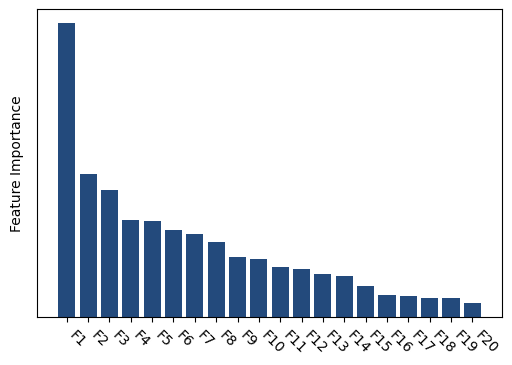

In [33]:
# Get feature importances from the CatBoost model
feature_importance = catboost_hse.feature_importances_

# Get feature names and their corresponding importances
feature_names_importance = list(zip(X_train.columns, feature_importance))

# Sort features by importance in descending order
sorted_feature_names_importance = sorted(feature_names_importance, key=lambda x: x[1], reverse=True)

# Select the top 20 features
top_features = sorted_feature_names_importance[:20]

# Separate feature names and importances
sorted_feature_names, sorted_feature_importance = zip(*top_features)

# Use a colormap where lighter colors indicate lower importance
color_map = LinearSegmentedColormap.from_list('custom', ['#dae9fd', '#234a7c'])

# Generate colors based on feature importance
colors = color_map(np.array(sorted_feature_importance) / max(sorted_feature_importance))

# Create new feature names list F1, F2, ..., F20
new_feature_names = ['F{}'.format(i + 1) for i in range(len(top_features))]

# Plot feature importance (using a logarithmic scale, with X and Y axes swapped)
plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(sorted_feature_importance)), np.log1p(sorted_feature_importance), color=colors, edgecolor='None', align='center')
plt.xticks(range(len(sorted_feature_importance)), new_feature_names, rotation=-45, ha='left')
plt.yscale('log')  # Use a logarithmic scale for the Y-axis
plt.ylabel('Feature Importance')  # Add Y-axis label
plt.yticks([])  # Hide Y-axis tick values
plt.tick_params(axis='y', which='both', left=False)  # Hide Y-axis ticks

# Add a color bar (optional)
sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=min(sorted_feature_importance), vmax=max(sorted_feature_importance)))
sm.set_array([])
plt.colorbar(sm, orientation='vertical', label='Feature Importance')

plt.show()

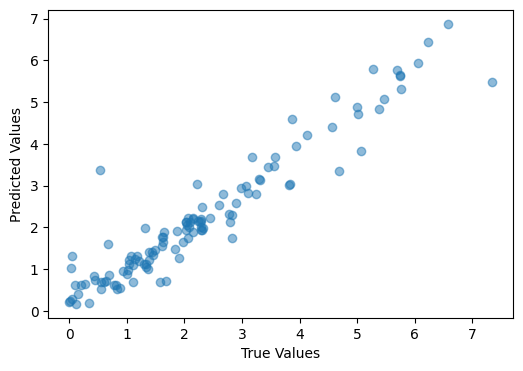

In [32]:
# Draw scatter plots
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
# plt.title('Scatter Plot of True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [30]:
# The predicted HSE bandgap is used as a feature to predict vbm
hse_pre=catboost_hse.predict(hseX)
newdf['hse_pre']=hse_pre
newdf

Formula  Bandgap(pbe)  Bandgap(HSE06)  cbm(pbe)  cbm(HSE06)  vbm(pbe)  \
2       Ca4As4         0.998           1.583    -1.024      -0.715    -2.022   
4       In2Se2         1.630           2.254    -2.271      -2.039    -3.901   
5        Sc4S6         1.515           2.939    -2.166      -1.320    -3.681   
8      Zr2Te10         0.191           0.142    -2.292      -2.128    -2.483   
9     Al2MgSe4         1.064           1.984    -0.789      -0.456    -1.853   
...        ...           ...             ...       ...         ...       ...   
4027   Hg2P2S6         1.020           1.894    -1.412      -1.178    -2.432   
4030  Ta2P2Se6         0.294           0.813    -0.799      -0.502    -1.093   
4031  Zr2P2Se6         0.394           1.074    -1.142      -0.712    -1.536   
4032  Mo2W2Se8         1.270           1.749     0.853       1.226    -0.417   
4033    FeZrI6         0.661           2.598    -0.849      -0.201    -1.510   

      vbm(HSE06)  Energy_above_hull  Space group number Space group  \
2         -2.298              0.350                  14      P2_1/c   
4         -4.293              0.038                  12        C2/m   
5         -4.259              0.263                  65        Cmmm   
8         -2.270              0.000                  59        Pmmn   
9         -2.440              0.000                 164       P-3m1   
...          ...                ...                 ...         ...   
4027      -3.072              0.020                 162       P-31m   
4030      -1.315              0.227                   2         P-1   
4031      -1.786              0.191                   2         P-1   
4032      -0.523              0.000                  25        Pmm2   
4033      -2.799              0.088                 149        P312   

     Fermi level  mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  \
2         -1.523         30.0              50.000                 0.467   
4         -3.086         28.9              50.000                 0.220   
5         -2.924         19.4              53.731                 0.466   
8         -2.387         38.0              39.912                 0.189   
9         -1.321         28.9              56.605                 0.152   
...          ...          ...                 ...                   ...   
4027      -1.922         19.4              58.267                 0.243   
4030      -0.946         28.9              54.882                 0.281   
4031      -1.339         28.9              55.976                 0.287   
4032       0.218         28.9              54.594                 0.371   
4033      -1.179         32.9              46.505                 0.199   

      meandiff_workfn  min_enthalpyAtomization  fwtmeandev_dipole  \
2               2.250                    178.0             65.400   
4               0.130                    227.0             18.050   
5               0.780                    279.0             37.248   
8               0.580                    197.0             20.588   
9               0.441                    146.0             16.347   
...               ...                      ...                ...   
4027            0.946                     64.0              4.826   
4030            0.916                    227.0             14.744   
4031            1.260                    227.0             26.904   
4032            0.934                    227.0             21.647   
4033            0.832                    107.0             20.288   

      mode_rad_p_orb  maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  \
2              0.745                  88.0        0.707           3.675   
4              0.670                  17.0        0.707           3.965   
5              0.560                  89.0        0.721           3.718   
8              0.880                  58.0        0.850           3.933   
9              0.670                  25.0        0.654           3.996   
...          

In [35]:
vbmX = pd.concat([newX, newdf[['Space group number', 'hse_pre']]], axis=1)
y = newdf['vbm(HSE06)']
X_train, X_test, y_train, y_test = train_test_split(vbmX, y, test_size=0.1, random_state=42)

params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate
    'n_estimators': 200,  # Number of trees
    'min_child_weight': 2,
    'subsample': 1.0,
    'verbosity': 0
}

# Create XGBRegressor model
xgb_vbm = xgb.XGBRegressor(**params)

xgb_vbm.fit(X_train, y_train)

y_pred = xgb_vbm.predict(X_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2:.2f}')
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

R2 Score: 0.91
Root Mean Squared Error (RMSE): 0.6339664617227121
Mean Absolute Error: 0.45621834820050455


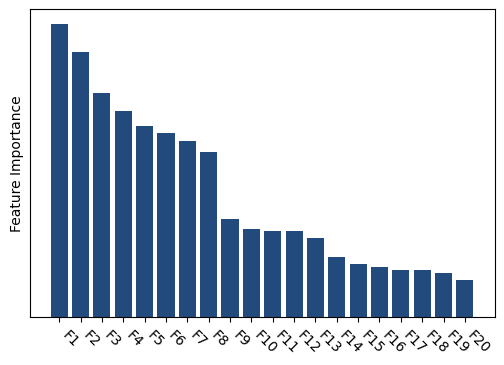

In [33]:
# AdaBoost Feature Importance

# Get feature importances from the XGBoost model
feature_importance = xgb_vbm.feature_importances_

# Get feature names and their corresponding importances
feature_names_importance = list(zip(X_train.columns, feature_importance))

# Sort features by importance in descending order
sorted_feature_names_importance = sorted(feature_names_importance, key=lambda x: x[1], reverse=True)

# Select the top 15 features
top_features = sorted_feature_names_importance[:15]

# Separate feature names and importances
sorted_feature_names, sorted_feature_importance = zip(*top_features)

# Use a custom colormap
color_map = LinearSegmentedColormap.from_list('custom', ['#dae9fd', '#234a7c'])

# Generate colors based on feature importance (lighter colors indicate lower importance)
colors = color_map(np.array(sorted_feature_importance) / max(sorted_feature_importance))

# Generate new feature names list F1, F2, ..., F15
new_feature_names = ['F{}'.format(i + 1) for i in range(len(top_features))]

# Plot feature importance (using a logarithmic scale for the Y-axis)
plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(sorted_feature_importance)), np.log1p(sorted_feature_importance), color=colors, edgecolor='None', align='center')
plt.xticks(range(len(sorted_feature_importance)), new_feature_names, rotation=-45, ha='left')
plt.ylabel('Feature Importance')  # Add Y-axis label
plt.yticks([])  # Hide Y-axis tick values
plt.tick_params(axis='y', which='both', left=False)  # Hide Y-axis ticks

plt.show()

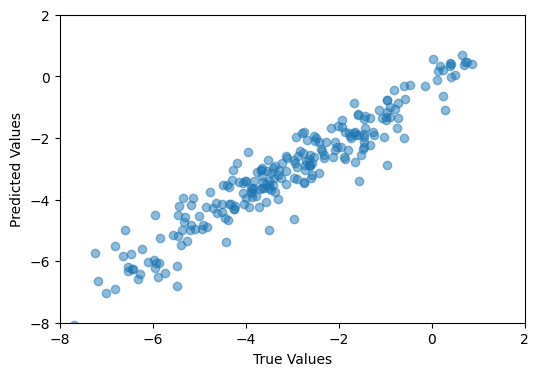

In [34]:
# Draw scatter plots
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
# plt.title('Scatter Plot of True vs Predicted Values')
plt.ylim([-8,2])
plt.xlim([-8,2])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [55]:
# Hull Stability Classification

hullX = pd.concat([newX, newdf[['Space group number']]], axis=1)

y = newdf['hullLable']

X_train, X_test, y_train, y_test = train_test_split(hullX, y, test_size=0.1, random_state=42)

# Use SMOTE for oversampling (uncomment to use)
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Create a CatBoost classifier
catboost_hull = CatBoostClassifier(
    iterations=200, 
    depth=6, 
    learning_rate=0.1, 
    loss_function='Logloss', 
    random_state=42
)

catboost_hull.fit(X_train, y_train)

y_pred = catboost_hull.predict(X_test)

# Calculate accuracy and other classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.4f" % precision)
print("Recall: %.4f" % recall)

0:	learn: 0.6424186	total: 6.79ms	remaining: 1.35s
1:	learn: 0.5990303	total: 11.1ms	remaining: 1.1s
2:	learn: 0.5600136	total: 16.3ms	remaining: 1.07s
3:	learn: 0.5245075	total: 20.1ms	remaining: 985ms
4:	learn: 0.4995367	total: 24ms	remaining: 937ms
5:	learn: 0.4780192	total: 27.9ms	remaining: 903ms
6:	learn: 0.4598415	total: 32.1ms	remaining: 886ms
7:	learn: 0.4473778	total: 36ms	remaining: 863ms
8:	learn: 0.4343047	total: 39.7ms	remaining: 842ms
9:	learn: 0.4243304	total: 43.5ms	remaining: 826ms
10:	learn: 0.4111867	total: 47.1ms	remaining: 810ms
11:	learn: 0.4043946	total: 51ms	remaining: 798ms
12:	learn: 0.3966198	total: 54.8ms	remaining: 788ms
13:	learn: 0.3872888	total: 58.5ms	remaining: 777ms
14:	learn: 0.3817566	total: 62.5ms	remaining: 771ms
15:	learn: 0.3731845	total: 66.3ms	remaining: 763ms
16:	learn: 0.3650221	total: 70.9ms	remaining: 763ms
17:	learn: 0.3530965	total: 74.9ms	remaining: 757ms
18:	learn: 0.3462636	total: 79ms	remaining: 752ms
19:	learn: 0.3413827	total: 83.

In [36]:
# XGBR regression for vbm, including Fermi level as a feature

X = pd.concat([newX, newdf['Fermi level']], axis=1)
y = newdf['vbm(HSE06)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 5,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate
    'n_estimators': 200,  # Number of trees
    'min_child_weight': 2,
    'subsample': 1.0,
    'verbosity': 0
}

# Create XGBRegressor model
xgb_vbm = xgb.XGBRegressor(**params)

xgb_vbm.fit(X_train, y_train)

y_pred = xgb_vbm.predict(X_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2:.2f}')
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error:", mae)

R2 Score: 0.94
Root Mean Squared Error (RMSE): 0.4731775784905727
Mean Absolute Error: 0.32926831351137464


In [56]:
# Predict the combination of double perovskites
new_comp=pd.read_csv("grj-new-double-pervoskite-magpie.csv")
new_comp

Unnamed: 0     formula        element_charge   A  B1  B2   X  \
0              0    Be2ScVO6    Be:2,Sc:3,V:5,O:-2  Be  Sc   V   O   
1              1    Be2ScVS6    Be:2,Sc:3,V:5,S:-2  Be  Sc   V   S   
2              2   Be2ScVSe6   Be:2,Sc:3,V:5,Se:-2  Be  Sc   V  Se   
3              3   Be2ScCrO6   Be:2,Sc:3,Cr:5,O:-2  Be  Sc  Cr   O   
4              4   Be2ScCrS6   Be:2,Sc:3,Cr:5,S:-2  Be  Sc  Cr   S   
...          ...         ...                   ...  ..  ..  ..  ..   
5185        5185   Ba2PtReS6   Ba:2,Pt:2,Re:6,S:-2  Ba  Pt  Re   S   
5186        5186  Ba2PtReSe6  Ba:2,Pt:2,Re:6,Se:-2  Ba  Pt  Re  Se   
5187        5187   Ba2PtOsO6   Ba:2,Pt:2,Os:6,O:-2  Ba  Pt  Os   O   
5188        5188   Ba2PtOsS6   Ba:2,Pt:2,Os:6,S:-2  Ba  Pt  Os   S   
5189        5189  Ba2PtOsSe6  Ba:2,Pt:2,Os:6,Se:-2  Ba  Pt  Os  Se   

      mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  meandiff_workfn  \
0             5.3              73.648                 0.381            0.832   
1            19.4              60.680                 0.290            0.832   
2            28.9              57.409                 0.263            0.832   
3             5.3              73.995                 0.386            0.912   
4            19.4              60.979                 0.294            0.912   
...           ...                 ...                   ...              ...   
5185         19.4              66.892                 0.538            1.758   
5186         28.9              63.573                 0.485            1.758   
5187          5.3              79.043                 0.719            1.811   
5188         19.4              66.820                 0.537            1.811   
5189         28.9              63.500                 0.484            1.811   

      min_enthalpyAtomization  fwtmeandev_dipole  mode_rad_p_orb  \
0                       249.0             28.594            0.18   
1                       279.0             21.826            0.56   
2                       227.0             19.485            0.67   
3                       249.0             28.114            0.18   
4                       279.0             21.346            0.56   
...                       ...                ...             ...   
5185                    182.0             77.984            0.56   
5186                    182.0             75.704            0.67   
5187                    182.0             81.568            0.18   
5188                    182.0             78.184            0.56   
5189                    182.0             75.904            0.67   

      maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  maxdiff_atmnum  \
0                     88.0        0.648           4.178            19.0   
1                     89.0        0.648           4.178            19.0   
2                     90.0        0.648           4.178            30.0   
3                     88.0        0.648           4.218            20.0   
4                     89.0        0.648           4.218            20.0   
...                    ...          ...             ...             ...   
5185                  91.0        0.648           3.967            62.0   
5186                  92.0        0.648           3.967            44.0   
5187                  90.0        0.648           3.987            70.0   
5188                  91.0        0.648           3.987            62.0   
5189                  92.0        0.648           3.987            44.0   

      maxdiff_eneg_rahm  fwtmean_eneg_rahm  fwtmeandev_NpValence  \
0                 11.52            -14.681                  1.92   
1                  6.59            -11.723                  1.92   
2                  6.17            -11.471                  1.92   
3                 11.52            -14.511                  1.92   
4                  6.59            -11.553                  1.92   
...                 ...                ...                   ...   
5185      

In [57]:
# new_comp.dropna(axis=1,how='all',inplace=True)
# new_comp.dropna(axis=0,how='any',inplace=True)
# new_comp.drop_duplicates(subset=['formula','element_charge'])

In [58]:
new_comp['Space group number'] = 162
new_comp

Unnamed: 0     formula        element_charge   A  B1  B2   X  \
0              0    Be2ScVO6    Be:2,Sc:3,V:5,O:-2  Be  Sc   V   O   
1              1    Be2ScVS6    Be:2,Sc:3,V:5,S:-2  Be  Sc   V   S   
2              2   Be2ScVSe6   Be:2,Sc:3,V:5,Se:-2  Be  Sc   V  Se   
3              3   Be2ScCrO6   Be:2,Sc:3,Cr:5,O:-2  Be  Sc  Cr   O   
4              4   Be2ScCrS6   Be:2,Sc:3,Cr:5,S:-2  Be  Sc  Cr   S   
...          ...         ...                   ...  ..  ..  ..  ..   
5185        5185   Ba2PtReS6   Ba:2,Pt:2,Re:6,S:-2  Ba  Pt  Re   S   
5186        5186  Ba2PtReSe6  Ba:2,Pt:2,Re:6,Se:-2  Ba  Pt  Re  Se   
5187        5187   Ba2PtOsO6   Ba:2,Pt:2,Os:6,O:-2  Ba  Pt  Os   O   
5188        5188   Ba2PtOsS6   Ba:2,Pt:2,Os:6,S:-2  Ba  Pt  Os   S   
5189        5189  Ba2PtOsSe6  Ba:2,Pt:2,Os:6,Se:-2  Ba  Pt  Os  Se   

      mode_dipole  varianceAtomRadius  fwtmeandev_rad_p_orb  meandiff_workfn  \
0             5.3              73.648                 0.381            0.832   
1            19.4              60.680                 0.290            0.832   
2            28.9              57.409                 0.263            0.832   
3             5.3              73.995                 0.386            0.912   
4            19.4              60.979                 0.294            0.912   
...           ...                 ...                   ...              ...   
5185         19.4              66.892                 0.538            1.758   
5186         28.9              63.573                 0.485            1.758   
5187          5.3              79.043                 0.719            1.811   
5188         19.4              66.820                 0.537            1.811   
5189         28.9              63.500                 0.484            1.811   

      min_enthalpyAtomization  fwtmeandev_dipole  mode_rad_p_orb  \
0                       249.0             28.594            0.18   
1                       279.0             21.826            0.56   
2                       227.0             19.485            0.67   
3                       249.0             28.114            0.18   
4                       279.0             21.346            0.56   
...                       ...                ...             ...   
5185                    182.0             77.984            0.56   
5186                    182.0             75.704            0.67   
5187                    182.0             81.568            0.18   
5188                    182.0             78.184            0.56   
5189                    182.0             75.904            0.67   

      maxdiff_mendeleevnum  Comp_L2Norm  fwtmean_workfn  maxdiff_atmnum  \
0                     88.0        0.648           4.178            19.0   
1                     89.0        0.648           4.178            19.0   
2                     90.0        0.648           4.178            30.0   
3                     88.0        0.648           4.218            20.0   
4                     89.0        0.648           4.218            20.0   
...                    ...          ...             ...             ...   
5185                  91.0        0.648           3.967            62.0   
5186                  92.0        0.648           3.967            44.0   
5187                  90.0        0.648           3.987            70.0   
5188                  91.0        0.648           3.987            62.0   
5189                  92.0        0.648           3.987            44.0   

      maxdiff_eneg_rahm  fwtmean_eneg_rahm  fwtmeandev_NpValence  \
0                 11.52            -14.681                  1.92   
1                  6.59            -11.723                  1.92   
2                  6.17            -11.471                  1.92   
3                 11.52            -14.511                  1.92   
4                  6.59            -11.553                  1.92   
...                 ...                ...                   ...   
5185      

In [59]:
# Predict pbe bandgap
newcom_pbe=rf_pbe.predict(new_comp[newXpbe.columns])
newcom_pbe


array([1.38316567, 0.62196685, 0.31021707, ..., 1.459459  , 0.7210662 ,
       0.58924397])

In [60]:
new_comp['pbe_pre']=newcom_pbe

In [61]:
# pbe_pre do feature prediction HSE
newcom_hse=catboost_hse.predict(new_comp[hseX.columns])
newcom_hse

array([3.24053898, 2.09546149, 1.12682006, ..., 2.49394877, 1.64485544,
       1.4554013 ])

In [62]:
new_comp['hse_pre']=newcom_hse

In [63]:
# Make characteristic prediction vbm for predicted HSE
newcom_vbm=xgb_vbm.predict(new_comp[vbmX.columns])
newcom_vbm


array([-5.316645 , -3.1199484, -1.6659923, ..., -3.3963199, -2.8823142,
       -2.5198803], dtype=float32)

In [64]:
new_comp['vbm_pre']=newcom_vbm

In [65]:
#predict hull
newcom_hull=catboost_hull.predict(new_comp[hullX.columns])
newcom_hull

array([1, 1, 1, ..., 1, 1, 1])

In [66]:
new_comp['hull_pre']=newcom_hull
new_comp['hull_pre'].value_counts()

hull_pre
1    5189
0       1
Name: count, dtype: int64

In [67]:
# # Calculate cbm with predicted HSE bandgap and vbm
new_comp['cbm_pre']=new_comp['hse_pre']+new_comp['vbm_pre']
# new_comp[['formula', 'vbm_pre', 'cbm_pre','hse_pre','hull_pre']]

In [71]:
#CORR
result=new_comp.loc[(new_comp['vbm_pre'] < -4.5) &(new_comp['cbm_pre'] > -4.26)& (new_comp['hull_pre'] == 1), ['formula', 'vbm_pre','cbm_pre', 'hse_pre','hull_pre']]

In [72]:
# Photocatalytic hydrolysis
# result=new_comp.loc[(new_comp['vbm_pre'] < -5.67) & (new_comp['hull_pre'] == 1), ['formula', 'vbm_pre','hse_pre','hull_pre']]

In [73]:
result

formula   vbm_pre   cbm_pre   hse_pre  hull_pre
0      Be2ScVO6 -5.316645 -2.076106  3.240539         1
3     Be2ScCrO6 -5.232982 -2.107027  3.125955         1
6     Be2ScMnO6 -5.700205 -2.674080  3.026125         1
9     Be2ScNbO6 -4.900568 -1.507067  3.393501         1
12    Be2ScMoO6 -5.228905 -1.873288  3.355617         1
...         ...       ...       ...       ...       ...
4044   Sr2CdWO6 -4.946719 -2.004473  2.942246         1
4047  Sr2CdReO6 -4.546908 -1.802954  2.743954         1
4050  Sr2CdOsO6 -4.794197 -1.978439  2.815758         1
4194   Ba2TiVO6 -4.508474 -1.678884  2.829590         1
4704  Ba2ZnMoO6 -4.600322 -1.575480  3.024841         1

[689 rows x 5 columns]

In [74]:
# Define a regular expression pattern to match the A2BB'O6 structure
pattern = re.compile(r'^([A-Z][a-z]?)(2)([A-Z][a-z]?)([A-Z][a-z]?)(O6)$')

filtered_data = result[result['formula'].apply(lambda x: bool(pattern.match(x)))]

# Display the filtered data
filtered_data

formula   vbm_pre   cbm_pre   hse_pre  hull_pre
0      Be2ScVO6 -5.316645 -2.076106  3.240539         1
3     Be2ScCrO6 -5.232982 -2.107027  3.125955         1
6     Be2ScMnO6 -5.700205 -2.674080  3.026125         1
9     Be2ScNbO6 -4.900568 -1.507067  3.393501         1
12    Be2ScMoO6 -5.228905 -1.873288  3.355617         1
...         ...       ...       ...       ...       ...
4044   Sr2CdWO6 -4.946719 -2.004473  2.942246         1
4047  Sr2CdReO6 -4.546908 -1.802954  2.743954         1
4050  Sr2CdOsO6 -4.794197 -1.978439  2.815758         1
4194   Ba2TiVO6 -4.508474 -1.678884  2.829590         1
4704  Ba2ZnMoO6 -4.600322 -1.575480  3.024841         1

[689 rows x 5 columns]

In [75]:
filtered_data = result[result['formula'].apply(lambda x: bool(pattern.match(x)))]
# filtered_data[['formula_pretty','hull','vbm','bandgap']]
filtered_data

formula   vbm_pre   cbm_pre   hse_pre  hull_pre
0      Be2ScVO6 -5.316645 -2.076106  3.240539         1
3     Be2ScCrO6 -5.232982 -2.107027  3.125955         1
6     Be2ScMnO6 -5.700205 -2.674080  3.026125         1
9     Be2ScNbO6 -4.900568 -1.507067  3.393501         1
12    Be2ScMoO6 -5.228905 -1.873288  3.355617         1
...         ...       ...       ...       ...       ...
4044   Sr2CdWO6 -4.946719 -2.004473  2.942246         1
4047  Sr2CdReO6 -4.546908 -1.802954  2.743954         1
4050  Sr2CdOsO6 -4.794197 -1.978439  2.815758         1
4194   Ba2TiVO6 -4.508474 -1.678884  2.829590         1
4704  Ba2ZnMoO6 -4.600322 -1.575480  3.024841         1

[689 rows x 5 columns]

In [76]:
def extract_elements(chemical_formula):
    """
    Extract elements from a chemical formula using regular expressions.
    
    Parameters:
    chemical_formula (str): The chemical formula to extract elements from.
    
    Returns:
    list: A list of elements extracted from the formula.
    """
    elements = re.findall(r'[A-Z][a-z]*', chemical_formula)
    return elements

filtered_data = result

filtered_data['A'] = filtered_data['formula'].apply(lambda x: extract_elements(x)[0] if extract_elements(x) else None)
filtered_data['B1'] = filtered_data['formula'].apply(lambda x: extract_elements(x)[1] if len(extract_elements(x)) > 1 else None)
filtered_data['B2'] = filtered_data['formula'].apply(lambda x: extract_elements(x)[2] if len(extract_elements(x)) > 2 else None)
filtered_data['X'] = filtered_data['formula'].apply(lambda x: extract_elements(x)[3] if len(extract_elements(x)) > 3 else None)

In [77]:
# Precious metals and radioactive elements, toxic elements
gmetals=['Au','Ag','Pt','Pd','Rh','Ir']
felements=['Tc','Pm','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md',
           'No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og']
delements=['Pb','Hg','As','Ta','Cr','V','Cs','Ru','Be','Tc','Y','Ru','Rh','Re','Os','']

In [78]:
filtered_data1=filtered_data[(~filtered_data['A'].isin(gmetals) & ~filtered_data['A'].isin(felements) & ~filtered_data['A'].isin(delements))&
                             (~filtered_data['B1'].isin(gmetals) & ~filtered_data['B1'].isin(felements)& ~filtered_data['B1'].isin(delements))&
                             (~filtered_data['B2'].isin(gmetals) & ~filtered_data['B2'].isin(felements)& ~filtered_data['B2'].isin(delements))]
filtered_data1

formula   vbm_pre   cbm_pre   hse_pre  hull_pre   A  B1  B2  X
1044  Mg2ScMnO6 -4.669653 -1.620044  3.049609         1  Mg  Sc  Mn  O
1047  Mg2ScNbO6 -4.860794 -1.272051  3.588743         1  Mg  Sc  Nb  O
1050  Mg2ScMoO6 -4.677805 -1.432043  3.245762         1  Mg  Sc  Mo  O
1065   Mg2ScWO6 -4.594194 -1.130346  3.463848         1  Mg  Sc   W  O
1089  Mg2TiMnO6 -5.400569 -2.279446  3.121123         1  Mg  Ti  Mn  O
...         ...       ...       ...       ...       ...  ..  ..  .. ..
3666  Sr2ZnMoO6 -4.886575 -1.772262  3.114314         1  Sr  Zn  Mo  O
3669   Sr2ZnWO6 -4.773818 -1.818667  2.955151         1  Sr  Zn   W  O
4041  Sr2CdMoO6 -4.944436 -1.807665  3.136771         1  Sr  Cd  Mo  O
4044   Sr2CdWO6 -4.946719 -2.004473  2.942246         1  Sr  Cd   W  O
4704  Ba2ZnMoO6 -4.600322 -1.575480  3.024841         1  Ba  Zn  Mo  O

[84 rows x 9 columns]

In [79]:
filtered_data1.drop_duplicates(subset=['formula'],inplace=True)

In [80]:
len(filtered_data1)

63

In [81]:
# Double B element
B_elements=['Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
           'Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd',
           'Lu','Hf','Ta','W','Re','Os','Ir',
          'Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn' ]

In [82]:
filtered_data2=filtered_data1[((filtered_data1['B1'].isin(B_elements) )&
                             (filtered_data1['B2'].isin(B_elements) ))]
len(filtered_data2)

63

In [83]:
filtered_data2.to_csv("CORR conduction and valence band values (write).csv")

In [191]:
filtered_data2

formula   vbm_pre   hse_pre  hull_pre   A  B1  B2  X
1047  Mg2ScNbO6 -4.984382  3.683698         1  Mg  Sc  Nb  O
1050  Mg2ScMoO6 -4.524685  3.500725         1  Mg  Sc  Mo  O
1065   Mg2ScWO6 -4.811134  3.533191         1  Mg  Sc   W  O
1089  Mg2TiMnO6 -5.278960  3.122801         1  Mg  Ti  Mn  O
1095  Mg2TiFeO6 -4.750061  3.110507         1  Mg  Ti  Fe  O
...         ...       ...       ...       ...  ..  ..  .. ..
4044   Sr2CdWO6 -4.936996  3.140724         1  Sr  Cd   W  O
4563  Ba2NiMnO6 -4.573588  2.419823         1  Ba  Ni  Mn  O
4698  Ba2ZnMnO6 -4.585541  2.331291         1  Ba  Zn  Mn  O
4701  Ba2ZnFeO6 -4.553866  2.319799         1  Ba  Zn  Fe  O
5076  Ba2CdFeO6 -4.503139  2.202370         1  Ba  Cd  Fe  O

[72 rows x 8 columns]

In [192]:
filtered_data2.to_csv("The CORR space group P-31m is finally selected.csv")

In [98]:
def optuna_objective(trial):
    """
    Objective function for Optuna optimization.
    
    This function defines the hyperparameter search space and evaluates the model using cross-validation.
    
    Parameters:
    trial (optuna.trial.Trial): Optuna trial object.
    
    Returns:
    float: Mean absolute cross-validation score (RMSE).
    """
    
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 80, 200, 1)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 20, 1)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 12, 1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10, 1)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    
    # Define the regressor with suggested hyperparameters
    reg = GBR(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=1412
    )
    
    # Perform cross-validation and output the negative root mean squared error (-RMSE)
    cv = KFold(n_splits=5, shuffle=True, random_state=1412)
    validation_loss = cross_validate(
        reg, newXvbm, yvbm,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        verbose=False,
        n_jobs=-1,
        error_score='raise'
    )
    
    # Return the mean RMSE
    return np.mean(np.abs(validation_loss["test_score"]))

In [99]:
def optimizer_optuna(n_trials, algo):
    """
    Optimize hyperparameters using Optuna with specified algorithm (TPE or GP).

    Parameters:
    n_trials (int): The number of trials to run the optimization.
    algo (str): The optimization algorithm to use ('TPE' or 'GP').

    Returns:
    tuple: A tuple containing the best hyperparameters and the best score.
    """
    if algo == "TPE":
        sampler = optuna.samplers.TPESampler(n_startup_trials=10, n_ei_candidates=24)
    elif algo == "GP":
        from optuna.integration import SkoptSampler
        import skopt
        sampler = SkoptSampler(skopt_kwargs={
            'base_estimator': 'GP',  # Use Gaussian Process
            'n_initial_points': 10,  # Number of initial points
            'acq_func': 'EI'  # Acquisition function: Expected Improvement
        })
    else:
        raise ValueError("Unsupported algorithm. Choose 'TPE' or 'GP'.")
    
    # Create the Optuna study with the specified sampler and direction
    study = optuna.create_study(sampler=sampler, direction="minimize")
    
    # Start the optimization process
    study.optimize(
        optuna_objective,  # Objective function to optimize
        n_trials=n_trials,  # Maximum number of trials
        show_progress_bar=True  # Show progress bar
    )
    
    print("\n\nBest parameters:", study.best_trial.params,
          "\n\nBest score:", study.best_trial.value,
          "\n")
    
    return study.best_trial.params, study.best_trial.value

In [100]:
best_params, best_score = optimizer_optuna(100,"TPE") 

[I 2024-01-16 11:57:16,710] A new study created in memory with name: no-name-31455b82-51ab-47af-a08a-7ab2f4a8c8a2


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-16 11:57:19,494] Trial 0 finished with value: 0.9188512977237628 and parameters: {'n_estimators': 148, 'learning_rate': 0.0250100571330776, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 0.22258205881555654}. Best is trial 0 with value: 0.9188512977237628.
[I 2024-01-16 11:57:21,562] Trial 1 finished with value: 0.9235977790181936 and parameters: {'n_estimators': 172, 'learning_rate': 0.08274360381184839, 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5753718293540369}. Best is trial 0 with value: 0.9188512977237628.
[I 2024-01-16 11:57:22,946] Trial 2 finished with value: 0.9300040095479138 and parameters: {'n_estimators': 88, 'learning_rate': 0.02221761368751439, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.6771229268181936}. Best is trial 0 with value: 0.9188512977237628.
[I 2024-01-16 11:57:25,172] Trial 3 finished with value: 0.9528344170110357 and parameters: {'n_es

In [57]:
# Recursive Feature Elimination (RFE) for feature selection, targeting cbm

estimator = LinearRegression()
'''
   Initialize the RFE selector
   n_features_to_select: Number of features to select
   step: Number of features to remove at each iteration
'''
selector = RFE(estimator, n_features_to_select=20, step=1)

selector = selector.fit(newXvbm, yvbm)

# Print the mask of selected features (True indicates the feature is selected)
print("Selected features mask:", selector.support_)

# Print the ranking of each feature (lower rank is better, 1 is the best)
print("Feature ranking:", selector.ranking_)

# Print the number of selected features
print("Number of selected features:", selector.n_features_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41]
20


In [58]:
# Get the ranking scores of the features
feature_ranking = selector.ranking_

# Get the indices of the features
feature_indices = range(len(feature_ranking))

# Create a dictionary containing feature indices and their rankings
feature_rank_dict = dict(zip(feature_indices, feature_ranking))

# Sort the features by their ranking scores
sorted_features = sorted(feature_rank_dict, key=feature_rank_dict.get)

# Select the top 20 features with the lowest ranking scores (best features)
top_features_indices = sorted_features[:20]

# Output the indices of the selected features
print("Top 20 Features Indices:", top_features_indices)

# Output the names of the selected features
top_features_names = newXvbm.columns[top_features_indices]
print("Top 20 Features Names:", top_features_names)

Top 15 Features Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Top 15 Features Names: Index(['fwtmeandev_rad_p_orb', 'Comp_L2Norm', 'fwtmeandev_NpValence',
       'fwtmean_zungerad', 'fwtmean_totunfilledelec', 'maxdiff_NsUnfValence',
       'fwtmean_NpUnfValence', 'fwtmean_NpValence', 'fwtmean_lquant',
       'min_lquant', 'fwtmean_eden', 'min_eden', 'meandiff_eden',
       'frelec_NpUnfValence', 'max_rahmrad', 'max_eneg_rahm',
       'fwtmean_eneg_rahm', 'maxdiff_eneg_rahm', 'mode_eden', 'mode_workfn'],
      dtype='object')


In [59]:
newXvbm=newXvbm[top_features_names]